<a href="https://colab.research.google.com/github/Rubeennn/Dog_Cat_dataset/blob/main/Cat_Dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip3 install -q kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d unmoved/30k-cats-and-dogs-150x150-greyscale

Dataset URL: https://www.kaggle.com/datasets/unmoved/30k-cats-and-dogs-150x150-greyscale
License(s): CC0-1.0
 99% 131M/133M [00:08<00:00, 20.2MB/s]
100% 133M/133M [00:08<00:00, 16.4MB/s]


In [ ]:
from pathlib import Path

data_path = Path('data')

data_path.mkdir(exist_ok=True, parents=True)


In [ ]:
import zipfile

with zipfile.ZipFile('30k-cats-and-dogs-150x150-greyscale.zip', 'r') as z:
    z.extractall(data_path)

In [ ]:
cat_path = data_path / 'Animal Images' / 'cats'
cat_path
dog_path = data_path / 'Animal Images' / 'dogs'

### Importing the necessary packages

In [ ]:
from torch.utils.data import random_split, DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
from tqdm.auto import tqdm
from PIL import Image
from torch import nn

import matplotlib.pyplot as plt
import pandas as pd
import torchvision
import numpy as np
import torch
import time
import os


Shape of the image is: (150, 150)


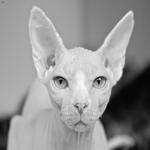

In [ ]:
# Visualizing one image
cat_image_names = os.listdir(cat_path)
first_cat_image_path = cat_path / cat_image_names[0]
img = Image.open(fp=first_cat_image_path)
print(f'Shape of the image is: {np.asarray(img).shape}')
img

2. Now we define the path to the image directory
and then gaining the dataset with **ImageFolder**.

In [ ]:
data_path

PosixPath('data')

In [ ]:
# Device agnostic code
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
dataset = ImageFolder(

    root = data_path / 'Animal Images',
    transform=transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize(size=(124,124)), # Maybe need to make it smaller
    transforms.ToTensor()
    ])
)

## 3. Bulding the model

In [ ]:
# Splitting the dataset into train, test and validation datasets.

torch.manual_seed(42)

train_size = int(len(dataset) * 0.7)
test_size = int(len(dataset) * 0.15)

val_size = len(dataset) - train_size - test_size

train_dataset, test_dataset, val_dataset = random_split(dataset,
                                                        [train_size,
                                                         test_size,
                                                         val_size]
                                                       )


1. Splitting data into batches using the *DataLoader*.

In [ ]:

BATCH_SIZE = 64

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=os.cpu_count()
                             )

test_loader = DataLoader(dataset=test_dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=False,
                        num_workers=os.cpu_count()
                        )

val_loader = DataLoader(dataset=val_dataset,
                       batch_size=BATCH_SIZE,
                       shuffle=False,
                       num_workers=os.cpu_count())

In [ ]:
dummy = torch.randint(0,255,size=(1,1,124,124),dtype=torch.float)
conv = nn.Conv2d(in_channels=1,
                                             out_channels=3,
                                             kernel_size=(3,3),
                                             stride=1,
                                             padding=0
                                            )
output = conv(dummy)
output.shape, dummy.shape

(torch.Size([1, 3, 122, 122]), torch.Size([1, 1, 124, 124]))

In [ ]:
class miniDogCat(nn.Module):
    def __init__(self, input_shape, hidden_shape,output_shape=1):
        super().__init__()

        self.block1 = nn.Sequential(nn.BatchNorm2d(num_features=1),
                                   nn.Conv2d(in_channels=1,
                                             out_channels=hidden_shape,
                                             kernel_size=(3,3),
                                             stride=1,
                                             padding=0
                                            ),
                                    nn.BatchNorm2d(num_features=hidden_shape),
                                    nn.ReLU(),
                                    nn.Conv2d(in_channels=hidden_shape,
                                              out_channels=hidden_shape,
                                              kernel_size=(3,3),
                                              stride=1,
                                              padding=0
                                    ),
                                    nn.BatchNorm2d(num_features=hidden_shape),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=(3,3),stride=2),
                                    nn.Dropout2d(p=0.15)
                                   )

        self.block2 = nn.Sequential(nn.BatchNorm2d(num_features=hidden_shape),
                                   nn.Conv2d(in_channels=hidden_shape,
                                             out_channels=hidden_shape,
                                             kernel_size=(3,3),
                                             stride=1,
                                             padding=0
                                            ),
                                    nn.BatchNorm2d(num_features=hidden_shape),
                                    nn.ReLU(),
                                    nn.Conv2d(in_channels=hidden_shape,
                                              out_channels=hidden_shape,
                                              kernel_size=(3,3),
                                              stride=1,
                                              padding=1
                                    ),
                                    nn.MaxPool2d(kernel_size=(3,3)),
                                    nn.BatchNorm2d(num_features=hidden_shape),
                                    nn.ReLU(),
                                    nn.Dropout2d(p=0.15))

        self.classifier = nn.Sequential(nn.Flatten(),
                                       nn.Linear(in_features=5415,
                                                out_features=124),
                                        nn.ReLU(),
                                        nn.Dropout2d(p=0.6),
                                        nn.Linear(in_features=124,
                                                 out_features=output_shape)
                                       )
    def forward(self, X):
        # print(X.shape)
        X = self.block1(X)
        # print(X.shape)
        X = self.block2(X)
        # print(X.shape)
        X = self.classifier(X)
        # print(X.shape)
        return X

In [ ]:
model = miniDogCat(input_shape=124,
              hidden_shape=15).to(device)

In [ ]:
dummy = torch.randint(0, 255, size=(1,1,124,124), dtype=torch.float).to(device)
model(dummy)

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1374: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


tensor([[-0.4527]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
optimizer = torch.optim.Adam(params=model.parameters(),
                       lr=0.001)

loss = nn.BCEWithLogitsLoss()

In [ ]:
len(train_dataloader)

329

In [ ]:
model

miniDogCat(
  (block1): Sequential(
    (0): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Conv2d(1, 15, kernel_size=(3, 3), stride=(1, 1))
    (2): BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Conv2d(15, 15, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Dropout2d(p=0.15, inplace=False)
  )
  (block2): Sequential(
    (0): BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Conv2d(15, 15, kernel_size=(3, 3), stride=(1, 1))
    (2): BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Conv2d(15, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=

In [ ]:
train_losses = []
train_accs = []
val_losses = []
val_accs = []

In [ ]:
epochs = 20
start_time = time.time()
for epoch in tqdm(range(epochs)):

    train_total_loss = 0
    train_total_acc = 0
    total_val_loss = 0
    total_val_acc = 0

    for batch , (X,y) in enumerate(train_dataloader):

        X, y = X.to(device), y.to(device)
        model.train()

        y_train_pred_logits = model(X)
        y = y.unsqueeze(dim=-1).to(torch.float)

        y_pred_probas = torch.round(torch.sigmoid(y_train_pred_logits))

        train_loss = loss(y_train_pred_logits, y)
        train_total_loss += train_loss.item()

        train_total_acc += (torch.sum(y_pred_probas == y).item() / len(y)) * 100

        optimizer.zero_grad()

        train_loss.backward()

        optimizer.step()

    train_total_loss /= len(train_dataloader)
    train_total_acc /= len(train_dataloader)
    train_losses.append(train_total_loss)
    train_accs.append(train_total_acc)

    with torch.inference_mode():
        model.eval()
        for (X_val, y_val) in val_loader:

            X_val, y_val = X_val.to(device), y_val.to(device)

            y_val_pred_logits = model(X_val)
            y_val_pred = torch.round(torch.sigmoid(y_val_pred_logits))

            y_val = y_val.unsqueeze(dim=-1).to(torch.float)

            val_loss = loss(y_val_pred_logits, y_val)
            total_val_loss += val_loss.item()

            total_val_acc += (torch.sum(y_val_pred == y_val).item() / len(y_val)) * 100

    total_val_loss /= len(val_loader)
    total_val_acc /= len(val_loader)
    val_losses.append(total_val_loss)
    val_accs.append(total_val_acc)

    print(f'Train loss: {train_total_loss:.4f},train_acc: {train_total_acc:.4f}, Val loss: {total_val_loss:.4f}, val_acc: {total_val_acc:.4f}')

end_time = time.time()
print(f'time spent: {end_time - start_time}')







  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 0.6524,train_acc: 61.5652, Val loss: 0.5689, val_acc: 71.3263
Train loss: 0.5823,train_acc: 70.0023, Val loss: 0.5254, val_acc: 74.6802
Train loss: 0.5418,train_acc: 73.4681, Val loss: 0.5002, val_acc: 75.6074
Train loss: 0.5142,train_acc: 74.9605, Val loss: 0.4683, val_acc: 77.2110
Train loss: 0.4938,train_acc: 76.7557, Val loss: 0.4591, val_acc: 77.7113
Train loss: 0.4806,train_acc: 76.9873, Val loss: 0.4493, val_acc: 78.4463
Train loss: 0.4607,train_acc: 78.4250, Val loss: 0.4476, val_acc: 78.6634
Train loss: 0.4516,train_acc: 79.0082, Val loss: 0.4352, val_acc: 79.0845
Train loss: 0.4338,train_acc: 79.7075, Val loss: 0.4318, val_acc: 79.3266
Train loss: 0.4245,train_acc: 80.6644, Val loss: 0.4301, val_acc: 79.6347
Train loss: 0.4111,train_acc: 81.0717, Val loss: 0.4211, val_acc: 79.5657
Train loss: 0.3997,train_acc: 81.5680, Val loss: 0.4099, val_acc: 80.4269
Train loss: 0.3878,train_acc: 82.4609, Val loss: 0.4123, val_acc: 80.9360
Train loss: 0.3812,train_acc: 82.9405,

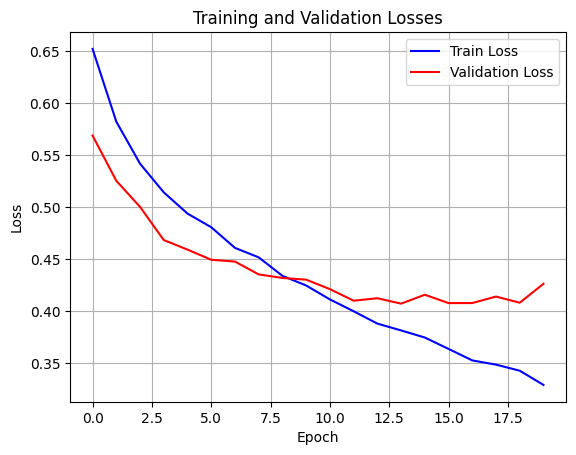

In [ ]:
plt.plot(range(len(train_losses)), train_losses, c='b', label='Train Loss')
plt.plot(range(len(val_losses)), val_losses, c='r', label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')

plt.legend()
plt.grid(True)
plt.show()


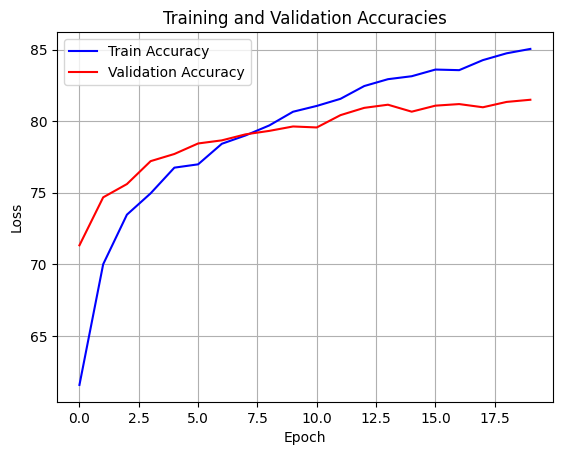

In [ ]:
plt.plot(range(len(train_accs)), train_accs, c='b', label='Train Accuracy')
plt.plot(range(len(val_accs)), val_accs, c='r', label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Accuracies')

plt.legend()
plt.grid(True)
plt.show()

###As we have a baseline model which has good results it is essetial to save the state_dict of our model to not repeat the training every time.

In [ ]:
torch.save(model.state_dict(), 'dog_cat_classifier.pth')

In [ ]:
from google.colab import files

files.download('dog_cat_classifier.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
missed_class_dict = {'misclassified_images' : [],
                     'misclassified_targets': [],
                     'predictions': []}

with torch.inference_mode():

  for value,targets in val_loader:
    value = value.to(device)
    targets = targets.to(device)
    model.eval()
    output = model(value)
    labels = torch.round(torch.sigmoid(output))
    for i in range(len(labels)):
      if labels[i] != targets[i]:
        missed_class_dict['misclassified_images'].append(value[i])
        missed_class_dict['misclassified_targets'].append(targets[i])
        missed_class_dict['predictions'].append(labels[i])



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1374: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


In [ ]:
missed_class_dict

{'misclassified_images': [tensor([[[0.2510, 0.2235, 0.2431,  ..., 0.2941, 0.2392, 0.1294],
           [0.2824, 0.2824, 0.3137,  ..., 0.3137, 0.3569, 0.2392],
           [0.2980, 0.3020, 0.3176,  ..., 0.3843, 0.3020, 0.3608],
           ...,
           [0.5647, 0.5804, 0.5686,  ..., 0.4784, 0.4980, 0.5373],
           [0.5686, 0.6000, 0.5804,  ..., 0.4863, 0.5255, 0.5255],
           [0.5569, 0.5922, 0.5725,  ..., 0.5137, 0.5451, 0.5098]]],
         device='cuda:0'),
  tensor([[[0.1255, 0.0941, 0.0706,  ..., 0.4353, 0.3333, 0.3137],
           [0.1294, 0.0980, 0.0745,  ..., 0.3961, 0.2941, 0.3059],
           [0.1333, 0.1098, 0.0863,  ..., 0.4627, 0.4000, 0.3647],
           ...,
           [0.4627, 0.3804, 0.3961,  ..., 0.2745, 0.2667, 0.2745],
           [0.4588, 0.4706, 0.4510,  ..., 0.2784, 0.2627, 0.2706],
           [0.5098, 0.5922, 0.5255,  ..., 0.2784, 0.2549, 0.2627]]],
         device='cuda:0'),
  tensor([[[0.2706, 0.2667, 0.3020,  ..., 0.4157, 0.3882, 0.3725],
           [0.3

In [85]:
class_names = train_dataset.dataset.classes
class_names

['cats', 'dogs']

To have a better idea about the whole process, It is a pertinent part to just visualize the images. Below are some images that have been misclassified from model, as we can see there are some simple images that have been misclassified, and some others that in my opinioin are little bit strange ones.

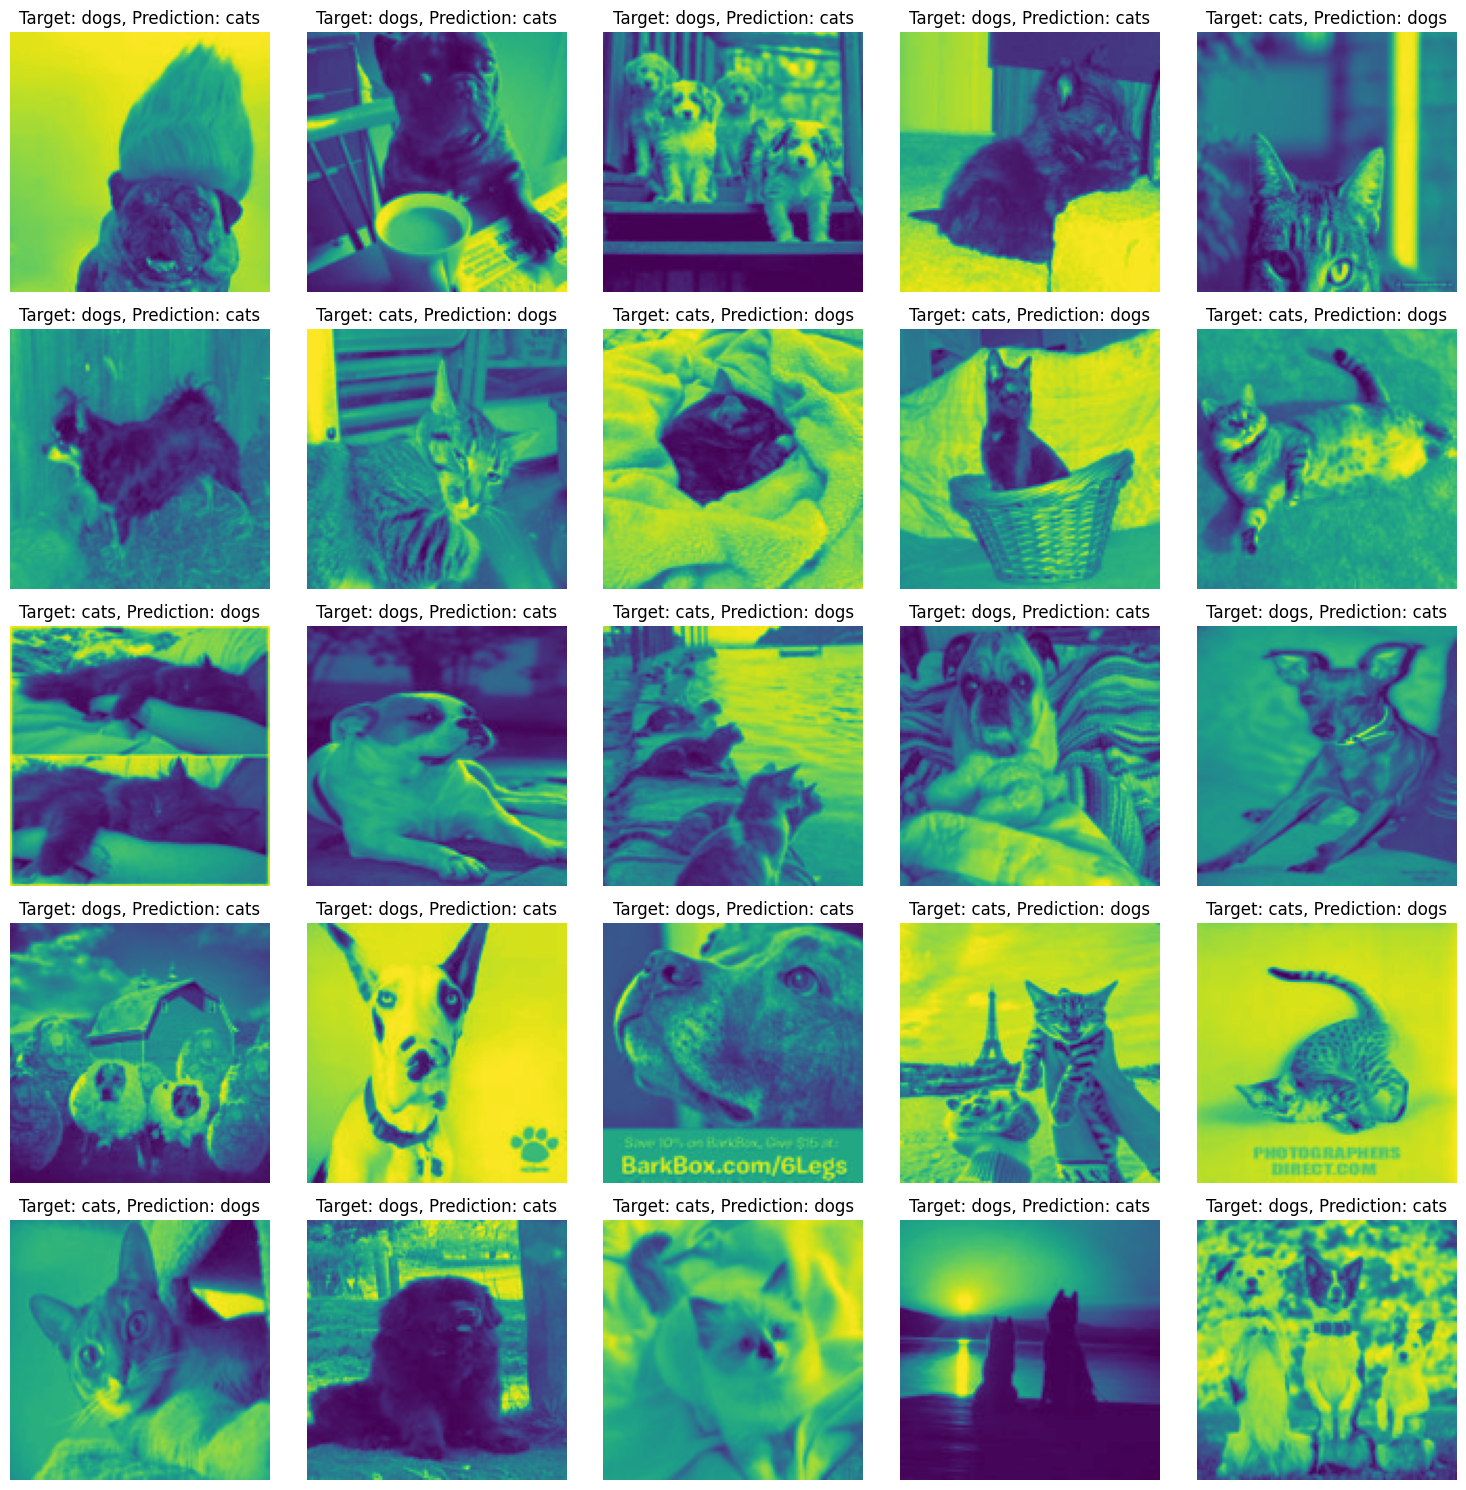

In [99]:
torch.manual_seed(42)
np.random.seed(42)

total_images = len(missed_class_dict['misclassified_images'])

random_indices = np.random.choice(total_images, size=25, replace=False)

random_indices = random_indices.tolist()
selected_images = [missed_class_dict['misclassified_images'][idx] for idx in random_indices]
selected_targets = [missed_class_dict['misclassified_targets'][idx] for idx in random_indices]
selected_predictions = [missed_class_dict['predictions'][idx] for idx in random_indices]

fig, axes = plt.subplots(5, 5, figsize=(15, 15))
axes = axes.flatten()

for i in range(25):
    image = selected_images[i].to('cpu')
    image = torch.permute(image,(1,2,0)).numpy()
    target = int(selected_targets[i].to('cpu'))
    prediction = int(selected_predictions[i].to('cpu'))

    axes[i].imshow(image)
    axes[i].set_title(f'Target: {class_names[target]}, Prediction: {class_names[prediction]}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()


In [96]:
int(torch.Tensor([1.0]))

1